# AutoEncoder 실습
- MNIST 데이터를 사용하여 autoencoder모델 구현 실습

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as T

import tensorflow as tf
import wandb

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [33]:
wandb.login(key='')
run = wandb.init(project='auto_encoder', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/kimhongseok/.netrc


In [3]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

## Data load

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

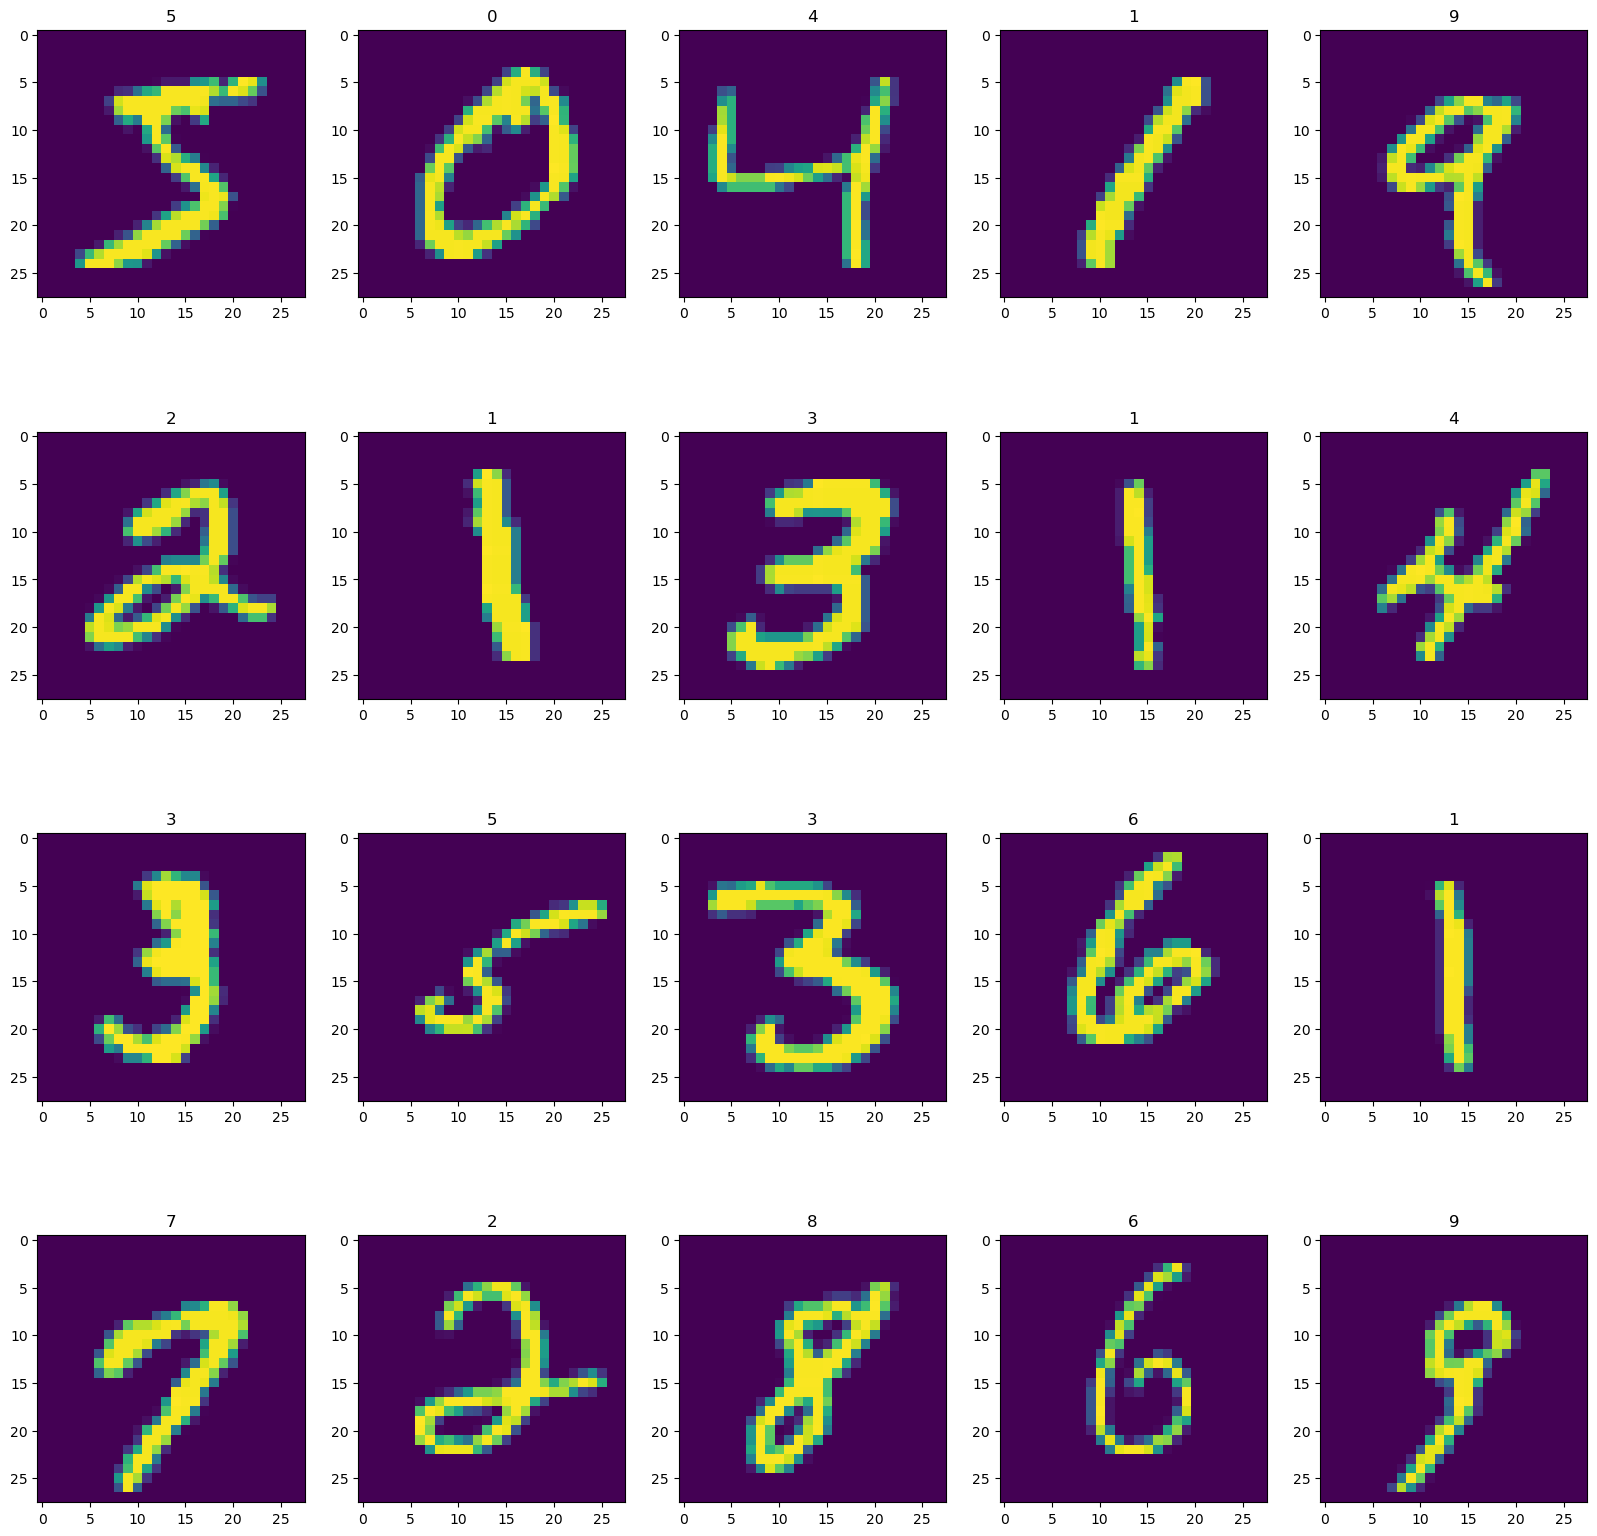

In [5]:
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(train_labels[i])

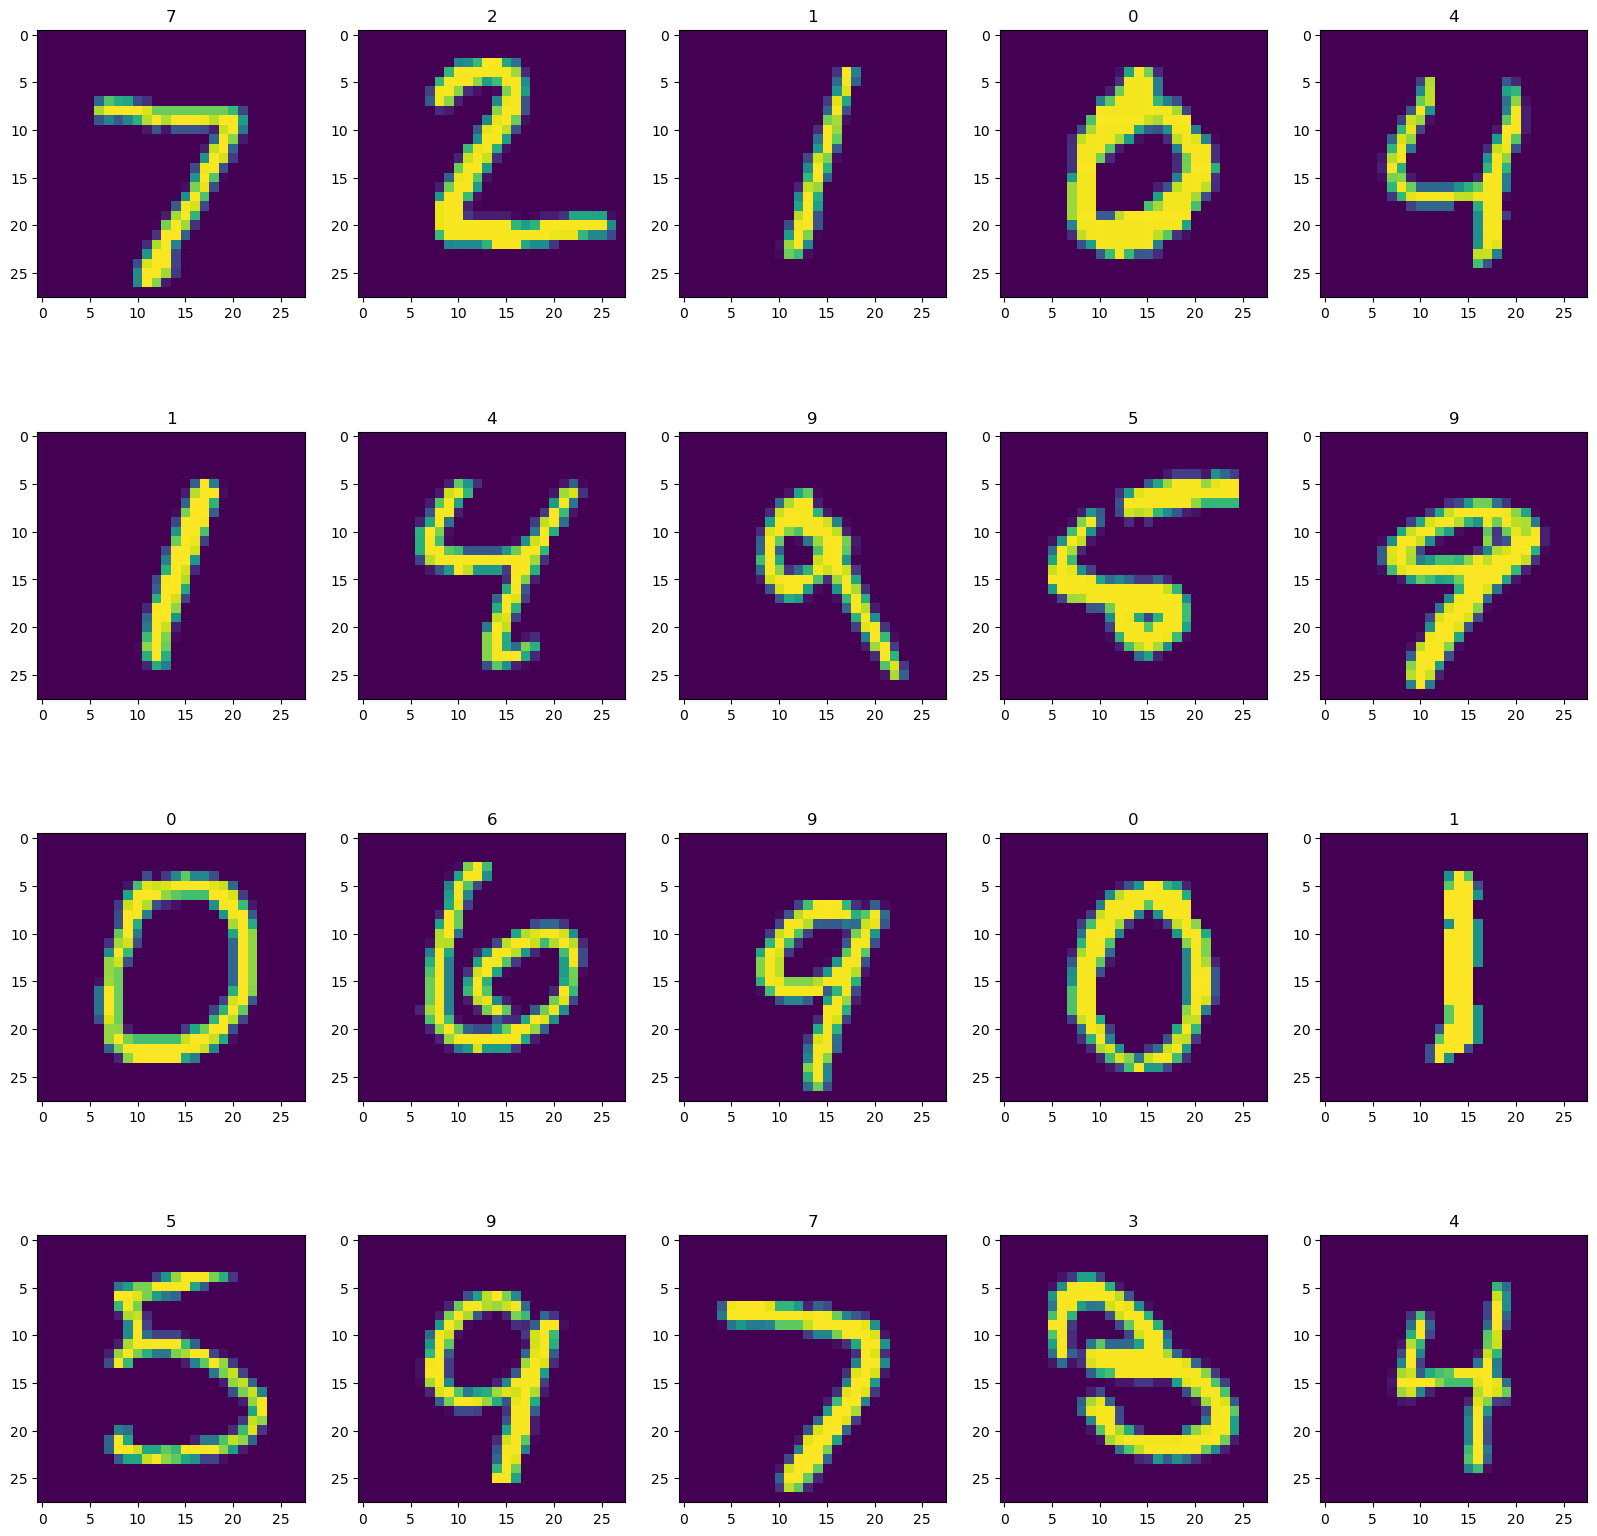

In [6]:
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_images[i])
    plt.title(test_labels[i])

## CustomDataset

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.data = list((transform(image), label) for image, label in zip(images, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
transform = T.Compose([T.ToTensor()])

train_dataset = CustomDataset(train_images, train_labels, transform)
test_dataset = CustomDataset(test_images, test_labels, transform)

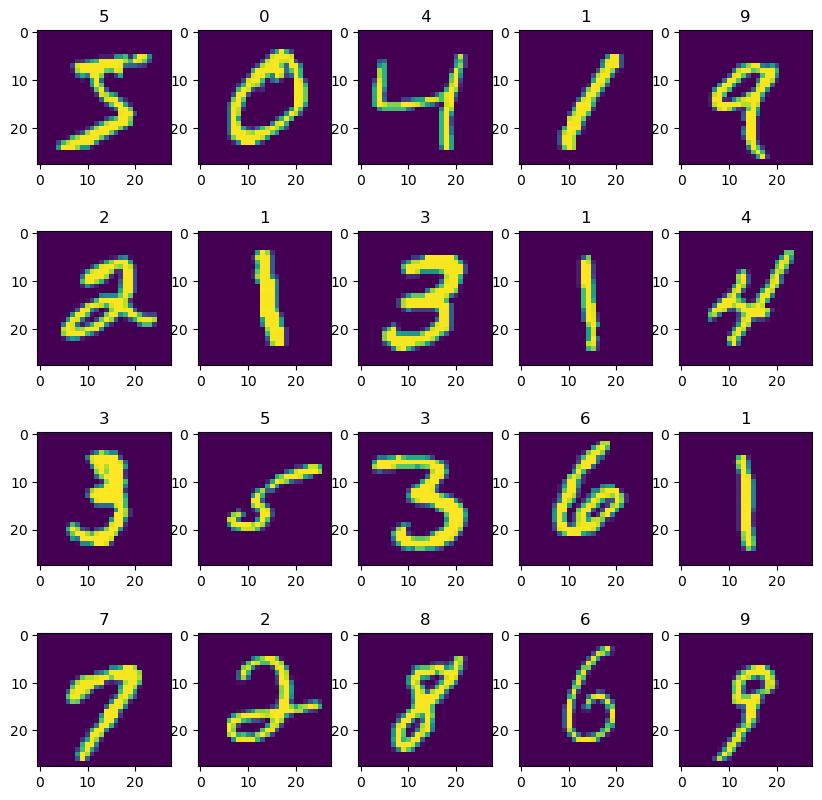

In [9]:
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(train_dataset[i][0].squeeze()))
    plt.title(train_dataset[i][1])

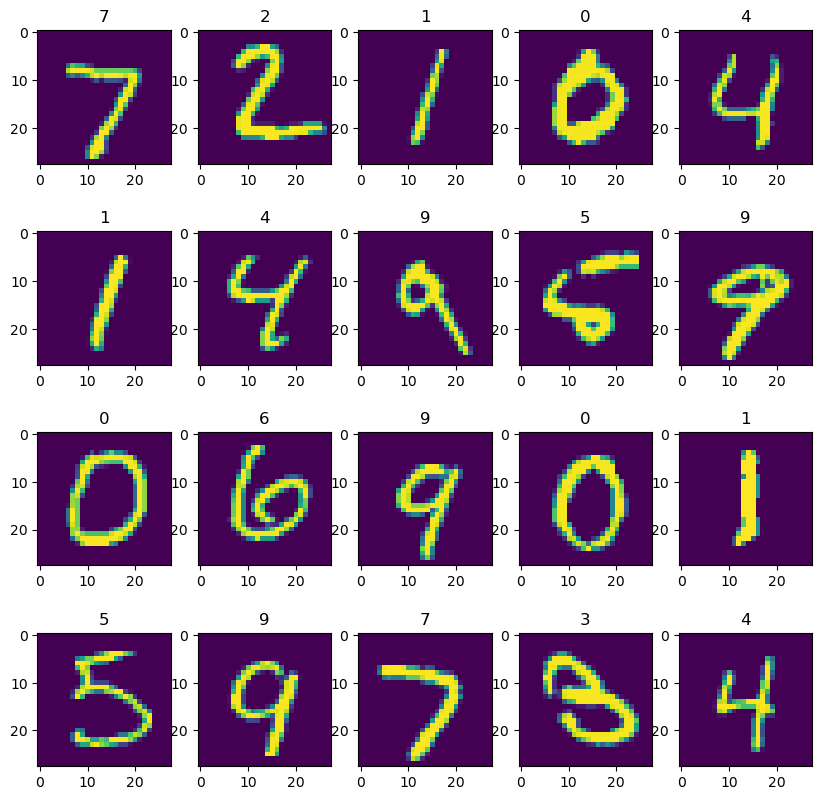

In [10]:
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(test_dataset[i][0].squeeze()))
    plt.title(test_dataset[i][1])

In [11]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [12]:
batch_size= 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## AutoEncoder Model
- Encoder
- Decoder

In [13]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 4)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(4, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(True),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 28*28)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## train 함수

In [14]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        y = images.view(-1, 28*28)
        encoded, decoded = model(images)
        loss = criterion(decoded, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        tbar.set_description(f'Epchs/Epochs: [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')
    
    train_loss = train_loss / len(train_dataloader)

    return model, train_loss

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            y = images.view(-1, 28*28)

            encoded, decoded = model(images)
            loss = criterion(decoded, y)

            valid_loss += loss.item()

            tbar.set_description(f'Epchs/Epochs: [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)

    return model, valid_loss

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        # monitoring_values = {'Training Loss': train_loss, 'Valid Loss': valid_loss}
        # run.log(monitoring_values, step=epoch)

    return model
        

In [15]:
model = Autoencoder()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

In [46]:
# run.finish()

Training Loss,█▄▃▃▂▂▁▁▁▁
Valid Loss,█▆▅▃▂▂▂▁▁▁
Training Loss,0.0312
Valid Loss,0.0313


## model test

In [16]:
model.eval()
total_decoded = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        y = images.view(-1, 28*28)
        encoded, decoded = model(images)
        
        total_decoded.extend(decoded)

  0%|          | 0/313 [00:00<?, ?it/s]

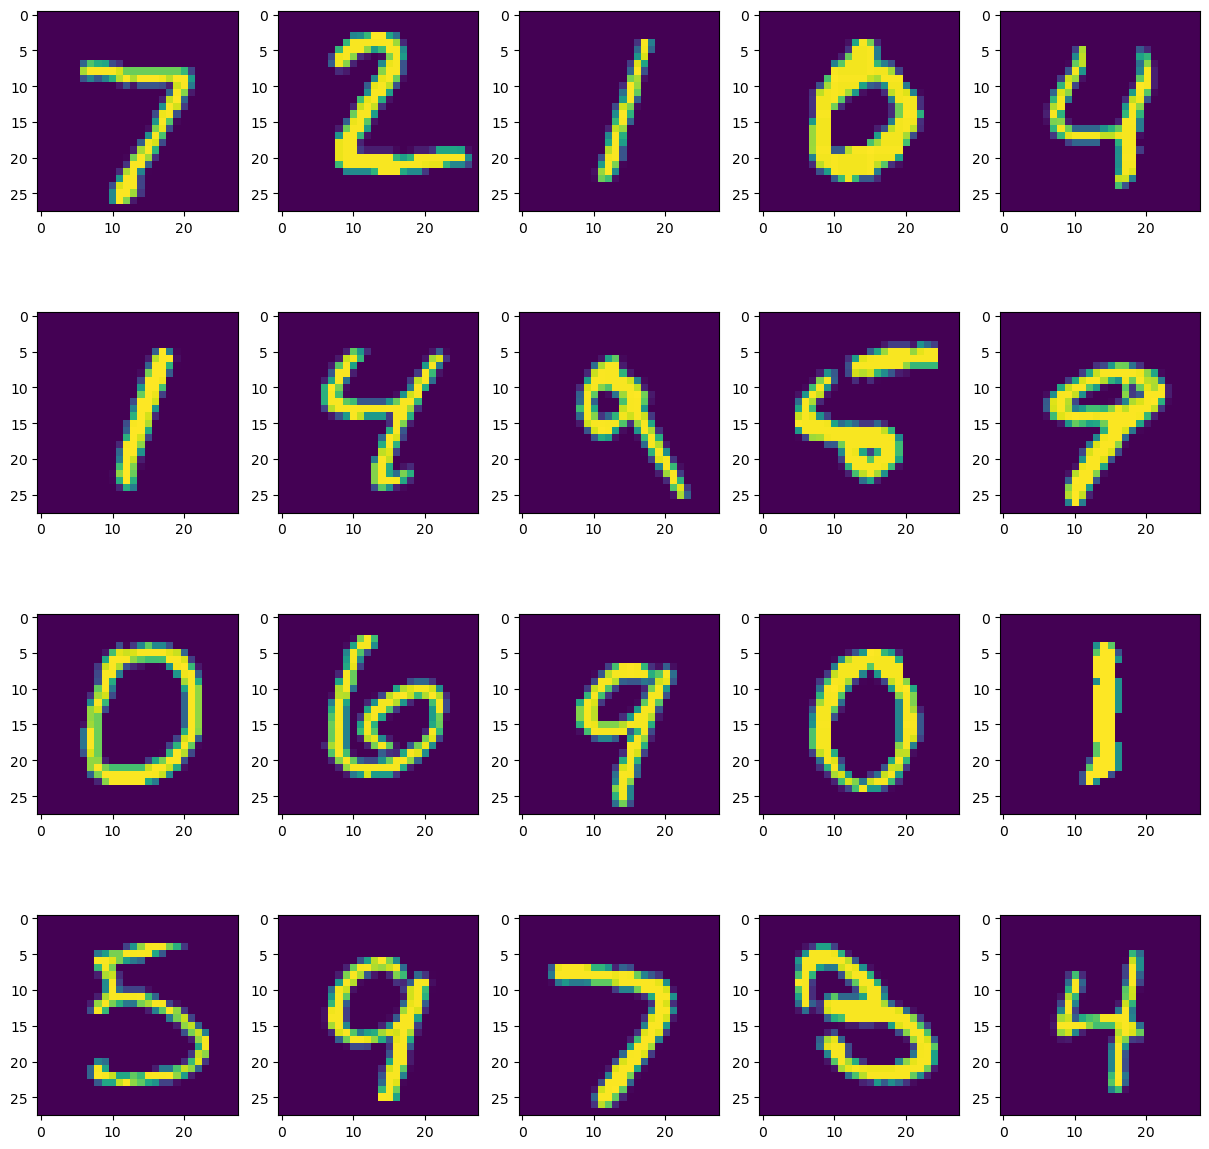

In [17]:
plt.figure(figsize=(15, 15))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].squeeze())

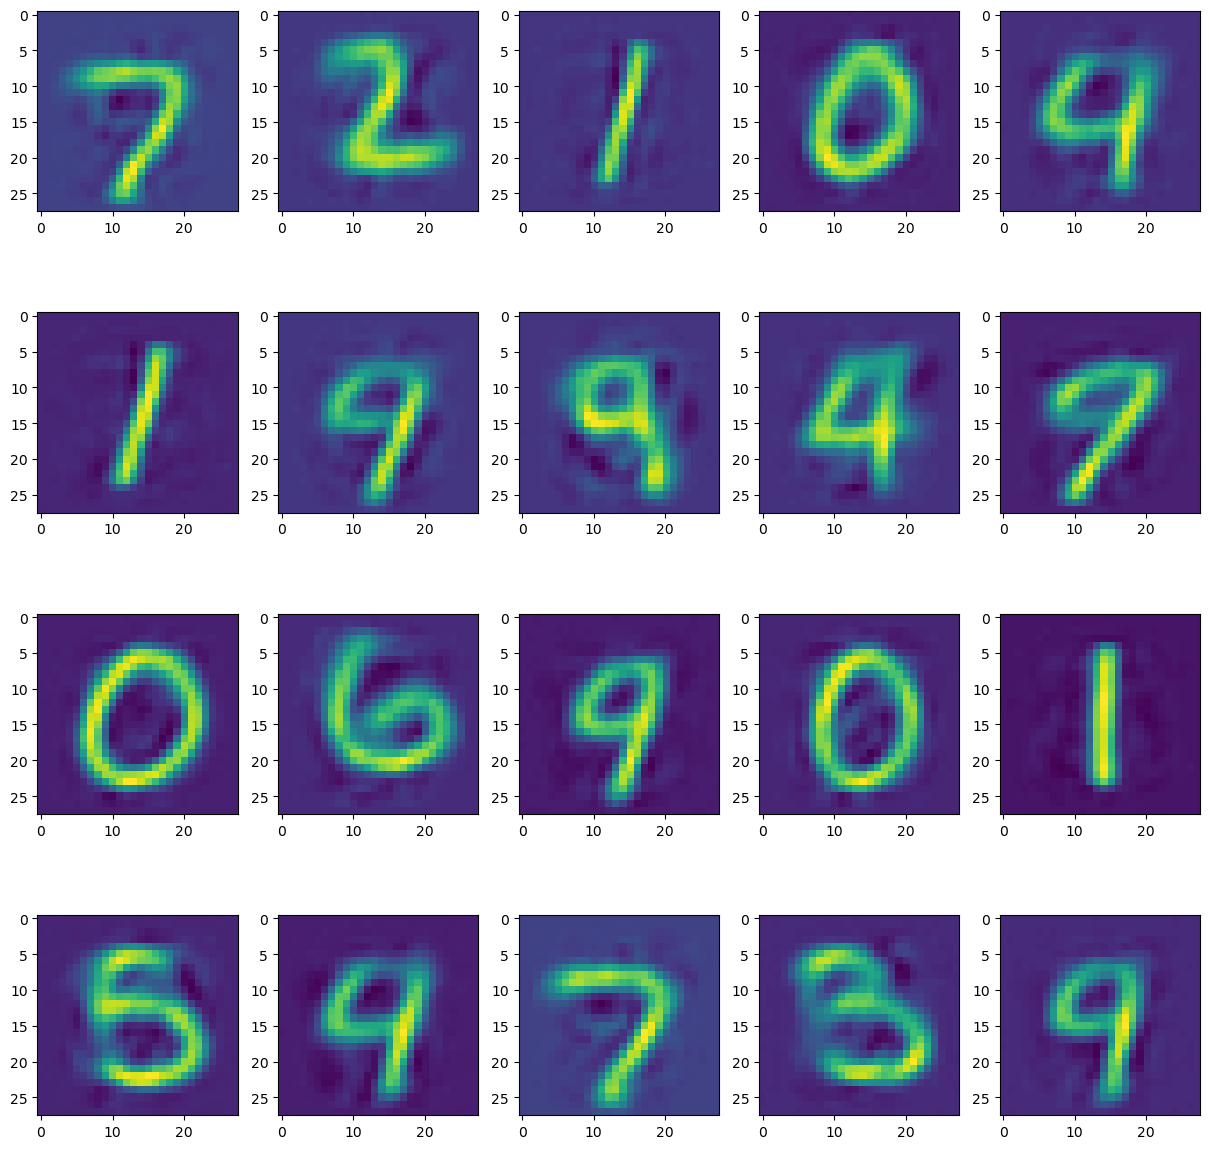

In [18]:
plt.figure(figsize=(15, 15))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_decoded[i].view(28, 28))